<img src="MCN.png" width="190" height="77">
<center>
    <b>Redes Neuronales</b><br>
<br><br>
<b>Resultado 1:</b>
<h1>Red Neural Recurrente (RNN)</h1>

<center>
Funciones para conjunto de datos de entranamiento
<center>

In [251]:
# *******************************************************************
#      Comenzaremos cargando los paquetes que se necesitan
# *******************************************************************
import copy
import random
import sys 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch

def ventana_deslizante(ts, longitud):
    X = []
    Y = []

    for i in range(longitud + 1, len(ts) + 1):
        X.append(ts[i - (longitud + 1):i - 1])
        Y.append([ts[i - 1]])

    return X, Y
# Función para obtener la serie de tiempo (ts)
def ob_serie_tiempo():
    df = pd.read_csv('SP500_Datos.csv')
    ts = df['y'].astype(int).values.reshape(-1,1)[-7322:]
    return ts

# Función para obtener los datos de entrenamiento 
def obt_datos_entrenamiento(ts,longitud,long_test):
    X,Y = ventana_deslizante(ts,longitud)
    
    X_entr, Y_entr, X_prueb, Y_prueb = X[0:-long_test],\
                                       Y[0:-long_test],\
                                       X[-long_test:],\
                                       Y[-long_test:]
                                       
    long_entr = round(len(ts)*0.7)
    
    X_entr, X_val, Y_entr, Y_val = X_entr[0:long_entr],\
                                   X_entr[long_entr:],\
                                   Y_entr[0:long_entr],\
                                   Y_entr[long_entr:]
                                   
    x_entr = torch.tensor(data = X_entr).float()
    y_entr = torch.tensor(data = Y_entr).float()
    
    x_val = torch.tensor(data = X_val).float()
    y_val = torch.tensor(data = Y_val).float()
    
    x_prueb = torch.tensor(data = X_prueb).float()
    y_prueb = torch.tensor(data = Y_prueb).float()
    
    return x_entr, x_val, x_prueb,\
           y_entr.squeeze(1), y_val.squeeze(1), y_prueb.squeeze(1)

<center>
Clase para la Red Neuronal Recurrente (RNN)
<center>

In [252]:
import torch.nn as nn

class RNN(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def forward(self, x, h = None):
        out, _ = self.rnn(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, last_hidden_states

<center>
Gráficamos la serie original
<center>

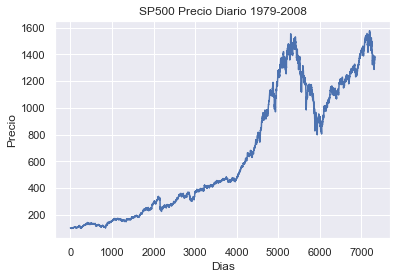

In [253]:
plt.title('SP500 Precio Diario 1979-2008')
plt.ylabel('Precio')
plt.xlabel('Dias')
plt.plot(ob_serie_tiempo())
plt.show()

<center>
Parámetros
<center>

In [254]:
# PARAMETROS

# Longitud de la ventana deslizante
longitud = 240

# Longitud del conjunto de datos de prueba
long_ts_prueba = 1900

# Tamaños ocultos de capas
tam_oculto_cap = 30

# Tasa de aprendizaje 
tasa_aprendizaje = 0.02

# Epocas
epochs_entrenamiento = 500

<center>
Datos de entrenamiento
<center>

In [255]:
# Preparando conjunto de datos para entrenamiento
ts = ob_serie_tiempo()
scalador = MinMaxScaler()
scalador_ts = scalador.fit_transform(ts)
x_entr, x_val, x_prueb, y_entr, y_val, y_prueb = obt_datos_entrenamiento(scalador_ts,longitud,long_ts_prueba)
print(len(x_entr), ': datos de entrenamiento ')
print(len(x_prueb), ': datos de prueba ')

5125 : datos de entrenamiento 
1900 : datos de prueba 


<center>
Creación del modelo
<center>

In [256]:
modelo = RNN(hidden_size=tam_oculto_cap)
modelo.train()

RNN(
  (rnn): RNN(1, 30, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

<center>
Entrenando los datos
<center>

In [259]:
random.seed(1)
torch.manual_seed(1)

# ENTRENAMIENTO
optimizador  =torch.optim.Adam(params=modelo.parameters(),lr=tasa_aprendizaje)
mse_loss = torch.nn.MSELoss()

best_model = None
min_val_loss = sys.maxsize

Entrenamiento_loss = []
validacion_loss = []

for epoch in range(epochs_entrenamiento):
    prediction, _ = modelo(x_entr)
    loss = mse_loss(prediction,y_entr)
    
    optimizador.zero_grad()
    loss.backward()
    optimizador.step()
    
    val_prediction, _ = modelo(x_val)
    val_loss = mse_loss(val_prediction,y_val)
    
    Entrenamiento_loss.append(loss.item())
    validacion_loss.append(validacion_loss)
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(modelo)
        min_val_loss = val_loss.item()
        
    if epoch % 50 == 0:
        print(f'epoch {epoch} - '
              f'Loss = {round(val_loss.item(), 6)}')
        
best_model.eval()
_, h_list = best_model(x_val)

epoch 0 - Loss = 0.059739
epoch 50 - Loss = 0.17426
epoch 100 - Loss = 6.2e-05
epoch 150 - Loss = 0.000899
epoch 200 - Loss = 0.000625
epoch 250 - Loss = 0.000422
epoch 300 - Loss = 0.000298
epoch 350 - Loss = 0.000223
epoch 400 - Loss = 0.000177
epoch 450 - Loss = 0.000149


In [260]:
# Estado Oculto
h = (h_list[-1, :]).unsqueeze(-2)

predicted = []
for test_seq in x_prueb.tolist():
    x = torch.Tensor(data = [test_seq])
    # pasando el estado oculto a través de cada iteración
    y, h = best_model(x, h.unsqueeze(-2))
    unscaled = scalador.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
    predicted.append(unscaled)
real = scalador.inverse_transform(y_prueb.tolist())

<center>
Gráfico de comparación
<center>

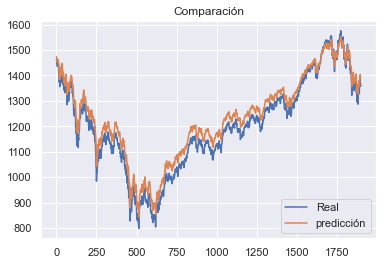

In [261]:
plt.title("Comparación")
plt.plot(real, label = 'Real')
plt.plot(predicted, label = 'predicción')
plt.legend()
plt.show()